In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as C
import pycountry

In [2]:
health_df = pd.read_csv("../data/ihme_data.csv")
aq_df = pd.read_csv("../data/openaq_data.csv")

aq_df.set_index("country", inplace=True)
aq_df[aq_df < 0] = None

In [3]:
def iso2_to_iso3(code):
    try:
        return pycountry.countries.get(alpha_2=code.upper()).alpha_3
    except:
        return None

health_df['iso3'] = health_df['country'].apply(iso2_to_iso3)
aq_df['iso3'] = aq_df.index.map(iso2_to_iso3)

In [4]:
shapefilepath = "../data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp"
world = gpd.read_file(shapefilepath)

In [5]:
# Function to map country names to ISO3 codes
def get_iso3(country_name):
    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except LookupError:
        return None

# Apply it to the ADMIN column
world['ISO_A3_fixed'] = world['ADMIN'].apply(get_iso3)

# Use the fixed ISO3 column only where original ISO_A3 is -99 or missing
world['ISO_A3'] = world.apply(
    lambda row: row['ISO_A3_fixed'] if row['ISO_A3'] in [None, '-99'] else row['ISO_A3'],
    axis=1
)

# Drop the helper column
world.drop(columns='ISO_A3_fixed', inplace=True)

In [6]:
health_merged = world.merge(health_df, how="left", left_on="ISO_A3", right_on="iso3")
aq_merged = world.merge(aq_df, how="left", left_on="ISO_A3", right_on="iso3")

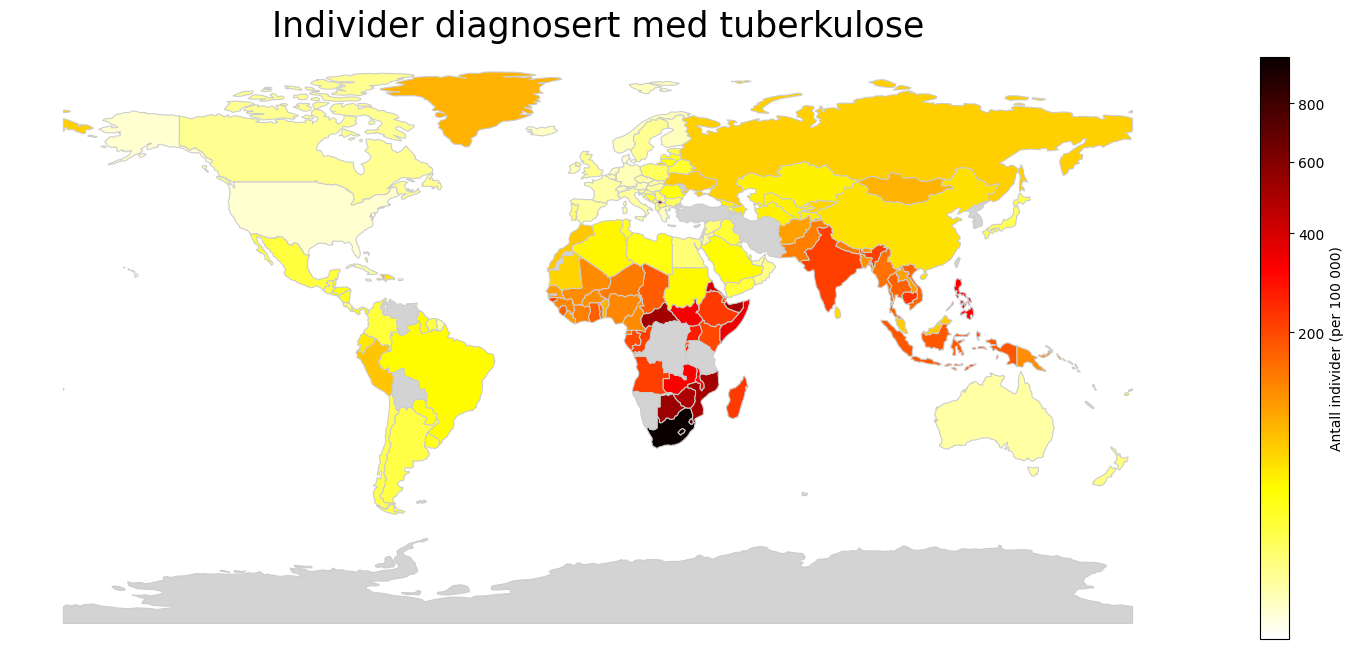

In [10]:
health_parameter = "tuberculosis"

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
health_merged.plot(column=health_parameter,
            cmap='hot_r',
            linewidth=0.8,
            ax=ax,
            edgecolor='0.8',
            legend_kwds = {
                "shrink": 0.6,
                #'ticks': [round(i, -2) for i in range(int(round(health_merged[health_parameter].min())), int(round(health_merged[health_parameter].max())), 100)],
                "label": "Antall individer (per 100 000)"
            },
            legend=True,
            missing_kwds={
                "color": "lightgrey",
                "label": "No data"
            },
            norm=C.PowerNorm(gamma=0.4, vmin=health_merged[health_parameter].min(), vmax=health_merged[health_parameter].max()),
            )
            

ax.set_title(f"Individer diagnosert med tuberkulose", fontsize=25)
ax.axis("off")
plt.tight_layout()
plt.show()

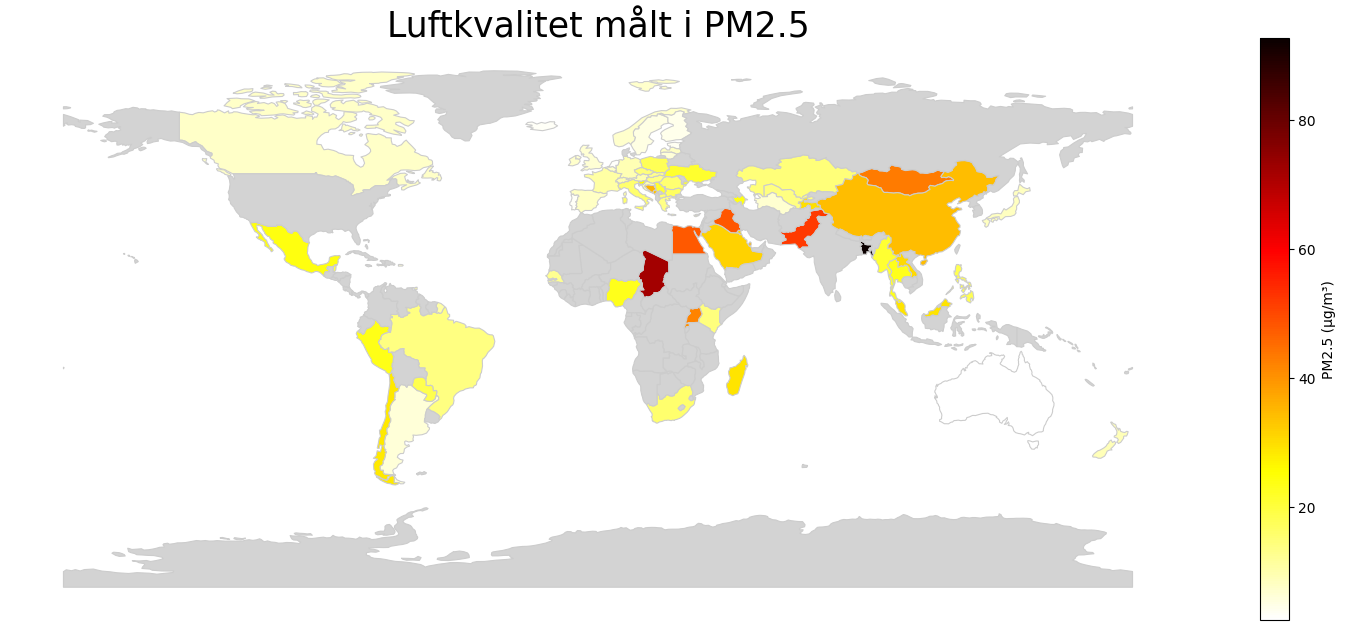

In [ ]:
aq_parameter = "pm25"

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
aq_merged.plot(column=aq_parameter,
            cmap='viridis_r',
            linewidth=0.8,
            ax=ax,
            edgecolor='0.8',
            legend_kwds = {
                "shrink": 0.6,
                "label": "PM2.5 (µg/m³)"
            },
            legend=True,
            missing_kwds={
                "color": "lightgrey",
                "label": "No data"
            },
            norm=C.PowerNorm(gamma=1, vmin=aq_merged[aq_parameter].min(), vmax=aq_merged[aq_parameter].max()),
            )
            

ax.set_title(f"Luftkvalitet målt i PM2.5", fontsize=25)
ax.axis("off")
plt.tight_layout()
plt.show()